In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats
import sklearn

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
flat_samples_exp=np.loadtxt("chain_EXP_FA_varimax.txt")

In [3]:
parameters=["Om","Ol","M","deltaM","a","b","sig"]
fit_results_exp={}
for i in range(7):
    percentile=np.percentile(flat_samples_exp[:,i],[16,50,84])
    fit_results_exp[parameters[i]]=[percentile[1],np.diff(percentile)[0],np.diff(percentile)[1]]

In [4]:
flat_samples_salt2=np.loadtxt("chain_SALT2_FA_varimax_subsample.txt")

In [5]:
parameters=["Om","Ol","M","deltaM","a","b","sig"]
fit_results_salt2={}
for i in range(7):
    percentile=np.percentile(flat_samples_salt2[:,i],[16,50,84])
    fit_results_salt2[parameters[i]]=[percentile[1],np.diff(percentile)[0],np.diff(percentile)[1]]

In [6]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\Delta_M",r"\alpha",r"\beta",r"\sigma_{int}"]
names_gdist = ["Om","Ol","M","deltaM","a","b","sig"]

In [7]:
samples_exp = MCSamples(samples=flat_samples_exp, names=names_gdist, labels=labels_gdist, label="EXP FA VARIMAX")

Removed no burn in


In [8]:
samples_salt2 = MCSamples(samples=flat_samples_salt2, names=names_gdist, labels=labels_gdist, label="SALT2")

Removed no burn in


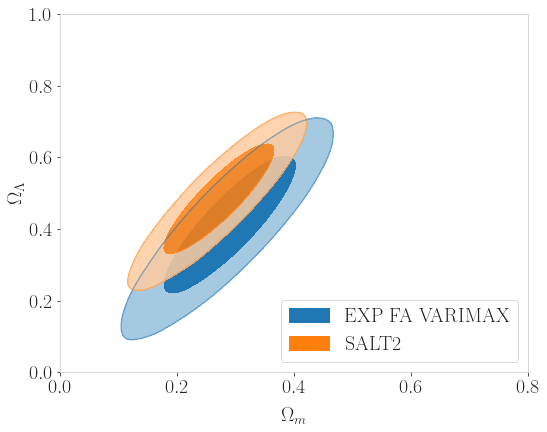

In [9]:
g = plots.get_single_plotter(width_inch=8, ratio=4 / 5.)
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.plot_2d([samples_exp, samples_salt2], ['Om', 'Ol'], filled=True, colors=["C0","C1"],lims=[0., 0.8,0., 1.]);
g.add_legend(["EXP FA VARIMAX","SALT2"], legend_loc=4);
plt.savefig('./OM_OL_plane_comparison_FA_varimax.pdf')  

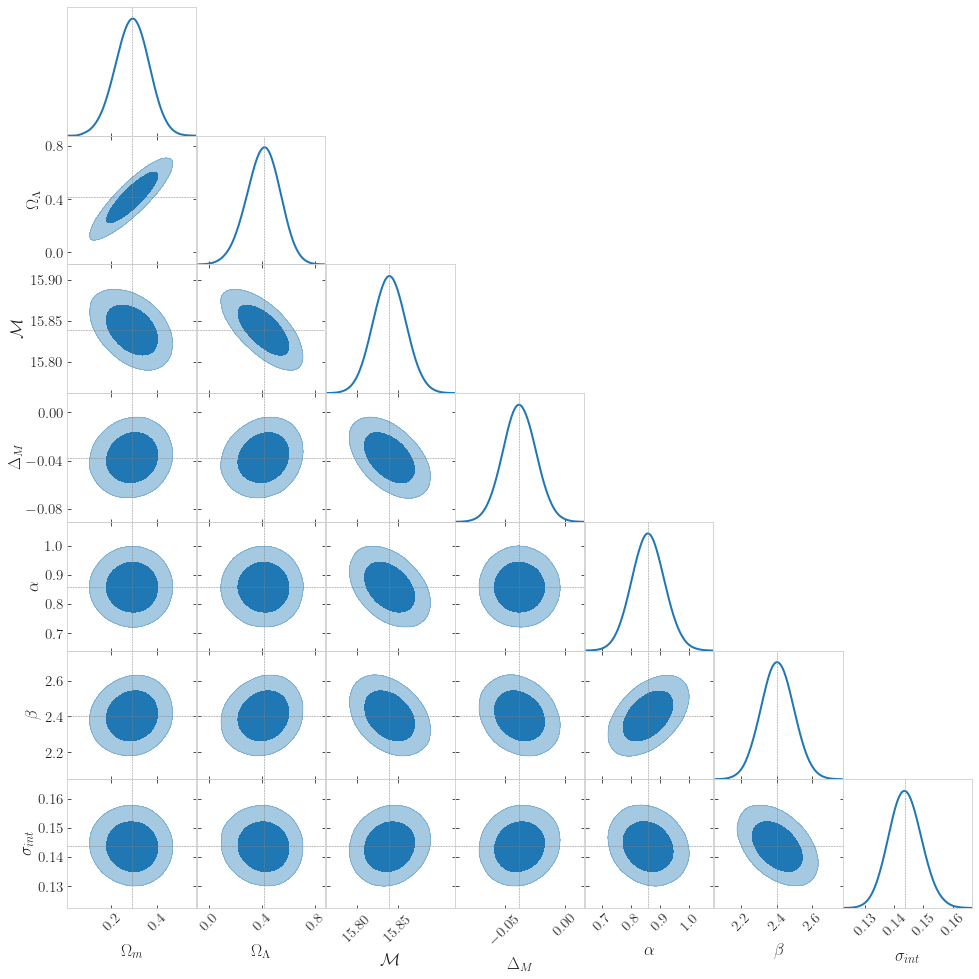

In [10]:
g = plots.get_subplot_plotter()
#g.settings.title_limit_fontsize = 15
g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
#g.settings.axis_marker_lw=0.5
g.triangle_plot([samples_exp], filled=True, line_args=[{'lw':2., 'color':"C0"}], contour_colors=["C0"], markers={'Om':fit_results_exp["Om"][0],'Ol':fit_results_exp["Ol"][0],'M':fit_results_exp["M"][0],'deltaM':fit_results_exp["deltaM"][0],'a':fit_results_exp["a"][0],'b':fit_results_exp["b"][0],'sig':fit_results_exp["sig"][0]}, marker_args={'lw':0.5})
plt.savefig('./cosmology_results_EXP_FA_varimax.pdf')  

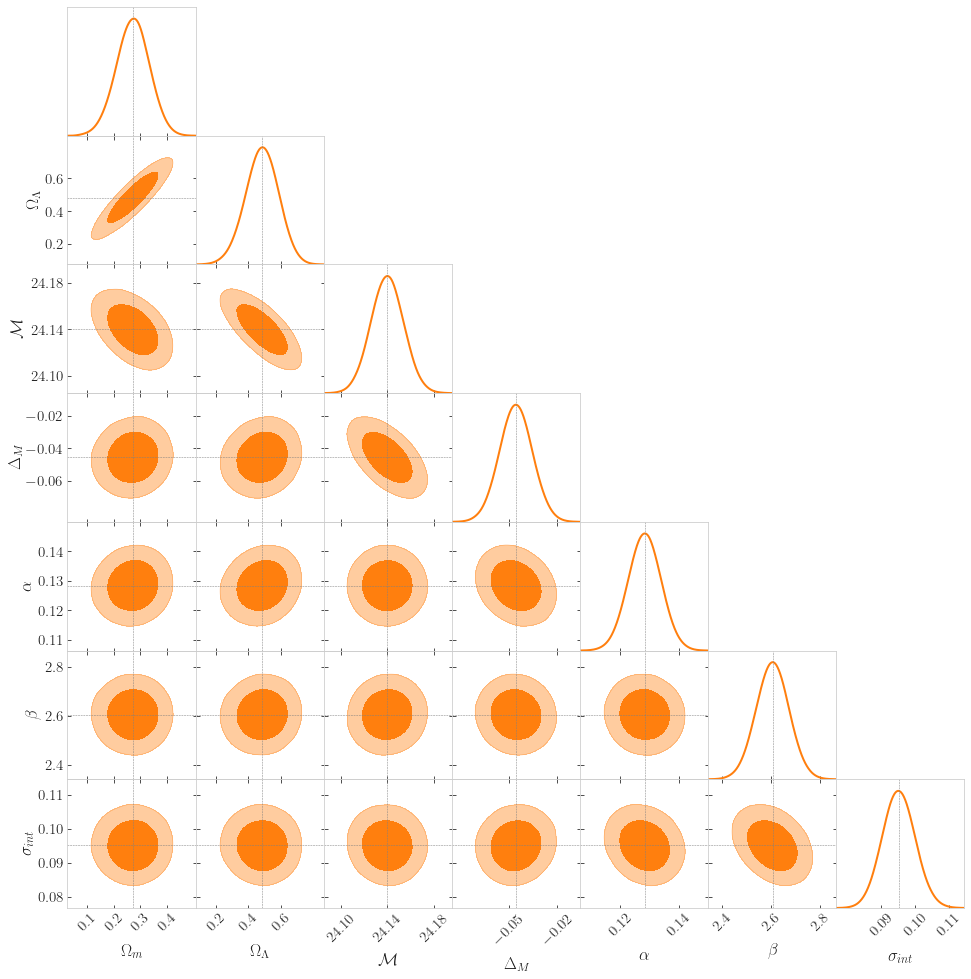

In [11]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 15
g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
#g.settings.axis_marker_lw=0.5
g.triangle_plot([samples_salt2], filled=True, line_args=[{'lw':2., 'color':"C1"}], contour_colors=["C1"], markers={'Om':fit_results_salt2["Om"][0],'Ol':fit_results_salt2["Ol"][0],'M':fit_results_salt2["M"][0],'deltaM':fit_results_salt2["deltaM"][0],'a':fit_results_salt2["a"][0],'b':fit_results_salt2["b"][0],'sig':fit_results_salt2["sig"][0]}, marker_args={'lw':0.5})
plt.savefig('./cosmology_results_SALT2_FA_varimax_subsample.pdf')

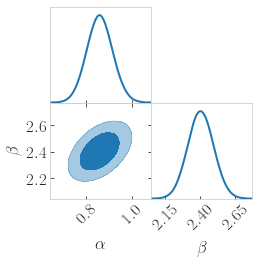

In [12]:
g = plots.get_subplot_plotter(subplot_size=2)
#g.settings.title_limit_fontsize = 13
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
#g.settings.axis_marker_lw=0.5
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot(samples_exp,params=['a', 'b'], filled=True,line_args={'lw':2., 'color':'C0'}, contour_colors=["C0"])
plt.savefig('./alpha_beta_triangle_plot_EXP_FA_varimax.pdf')  

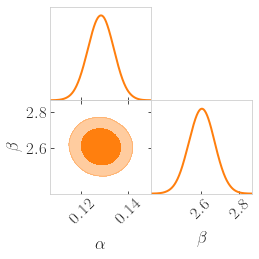

In [13]:
g = plots.get_subplot_plotter(subplot_size=2)
#g.settings.title_limit_fontsize = 13
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
#g.settings.axis_marker_lw=0.5
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot(samples_salt2,params=['a', 'b'], filled=True,line_args={'lw':2., 'color':'C1'}, contour_colors=["C1"])
plt.savefig('./alpha_beta_triangle_plot_SALT2_FA_varimax_subsample.pdf')  

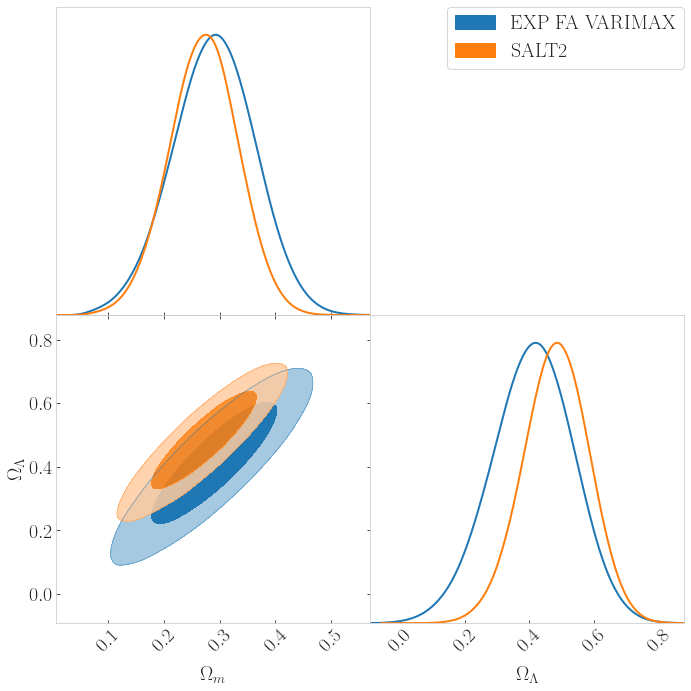

In [14]:
g = plots.get_subplot_plotter(subplot_size=5)
#g.settings.title_limit_fontsize = 13
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
#g.settings.axis_marker_lw=0.5
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot([samples_exp, samples_salt2], ['Om', 'Ol'], filled=True,line_args=[{'lw':2., 'color':'C0'},{'lw':2, 'color':'C1'}], contour_colors=["C0","C1"])
plt.savefig('./OM_OL_triangle_plot_comparison_FA_varimax.pdf')  

## Hubble Diagram

In [15]:
def mu(Om,Ol,M,red):
    Ok=1.-Om-Ol 
    h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
    integral=gk.integrate(h_inv,[np.array([0.]*len(red)),np.array(red)])
        
    if Ok==0:
        model=5*np.log10((1+red)*integral)+M
    elif Ok>0:
        model=5*np.log10((1+red)/np.sqrt(Ok)*np.sinh(np.sqrt(Ok)*integral))+M
    elif Ok<0:
        model=5*np.log10((1+red)/np.sqrt(-Ok)*np.sin(np.sqrt(-Ok)*integral))+M
    
    return model

In [16]:
fit_results_exp

{'Om': [0.29061040620015777, 0.07491238265927377, 0.07255111064464226],
 'Ol': [0.41251118000678233, 0.12942562989684198, 0.12259586221552021],
 'M': [15.839291782089681, 0.019903050803955935, 0.020068133946931965],
 'deltaM': [-0.03775391286716809, 0.013492450479389566, 0.013663916415487157],
 'a': [0.8579653359932514, 0.05567886203118966, 0.05652514150257815],
 'b': [2.40310691086959, 0.09146042307756597, 0.09256590627496974],
 'sig': [0.1436593922362766, 0.005520782850369499, 0.005712977503155109]}

In [17]:
fit_results_salt2

{'Om': [0.272334893633268, 0.06253174341543427, 0.060905029226828944],
 'Ol': [0.4837293137692168, 0.10263316148748736, 0.0997186524196072],
 'M': [24.140037345872084, 0.014042874740404443, 0.014090073670487868],
 'deltaM': [-0.0455724446089041, 0.010077524412551941, 0.010103442524054852],
 'a': [0.1283677646159622, 0.005574202899019262, 0.005558176946670906],
 'b': [2.606055749689218, 0.0670973368715555, 0.0667187743083213],
 'sig': [0.09512641288351828, 0.00482118679937639, 0.004890172658653491]}

In [18]:
Om=fit_results_exp["Om"][0]
Ol=fit_results_exp["Ol"][0]
M=fit_results_exp["M"][0]
deltaM=fit_results_exp["deltaM"][0]
alpha=fit_results_exp["a"][0]
beta=fit_results_exp["b"][0]
sigma=fit_results_exp["sig"][0]

In [19]:
data_exp=pd.read_csv("exp_FA_varimax_fits_table.txt")

In [20]:
len(data_exp)

794

In [21]:
data_exp=data_exp.sort_values("z").reset_index(drop=True)

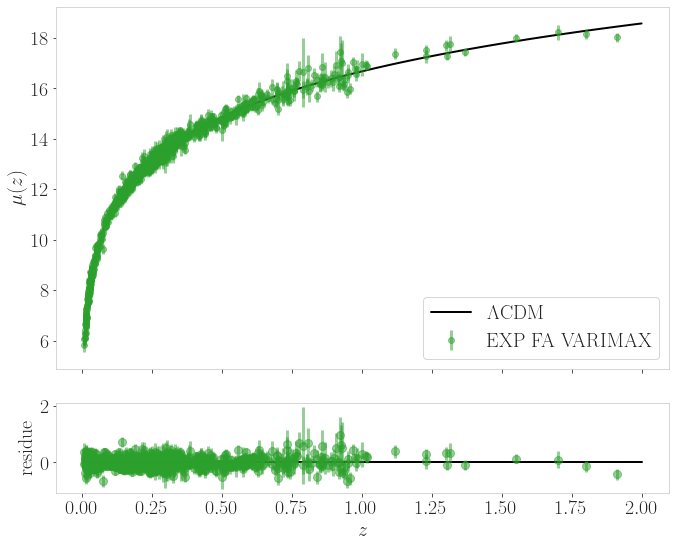

In [22]:
fig, ax=plt.subplots(2,1,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [4, 1]})

mu_exp=data_exp["mB"]-2.5*np.log10(1-alpha*data_exp["x1"]+beta*data_exp["x2"])-data_exp["is_log_mass_g_10"]*deltaM 
fator=-2.5/(np.log(10.)*(1-alpha*data_exp["x1"]+beta*data_exp["x2"]))

sigmaz=0.0012*(5/np.log(10.))*(1.+data_exp["z"])/(data_exp["z"]*(1.+data_exp["z"]/2.))
cov=-2.*alpha*fator*data_exp["cov_mB_x1"]+2*beta*fator*data_exp["cov_mB_x2"]-2*alpha*beta*fator**2*data_exp["cov_x1_x2"]
muerr_exp=sigma**2+sigmaz**2+data_exp["mBerr"]**2+alpha**2*fator**2*data_exp["x1err"]**2+beta**2*fator**2*data_exp["x2err"]**2+cov

ax[0].errorbar(data_exp["z"],mu_exp, yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=6,color="C2",zorder=1,mec = 'C2', mfc = 'C2',elinewidth=3,label="EXP FA VARIMAX",alpha=0.5)
ax[0].plot(np.linspace(0.01,2.,100),mu(Om,Ol,M,red=np.linspace(0.01,2.,100)),color="black",label=r"$\Lambda$CDM",lw=2,zorder=0)
ax[0].set_ylabel(r"$\mu(z)$")
ax[0].legend(loc=4)

ax[1].errorbar(data_exp["z"],mu_exp-mu(Om,Ol,M,red=data_exp["z"]),yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=8,color="C2",zorder=1,mec = 'C2', mfc = 'C2',elinewidth=3,alpha=0.5)
ax[1].plot(np.linspace(0.01,2.,100),[0]*100,color="black",lw=2,zorder=0)
ax[1].set_ylabel("residue")
ax[1].set_xlabel(r"$z$")

fig.tight_layout()
plt.savefig('./HD_EXP_FA_varimax.pdf',dpi=300);

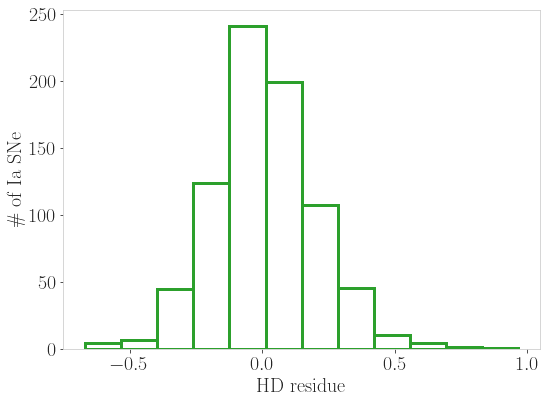

In [23]:
fig, ax=plt.subplots(figsize=(8,6))
                     
plt.hist(mu_exp-mu(Om,Ol,M,red=data_exp["z"]),bins=12,edgecolor="C2",fill=False,lw=3)
plt.ylabel("\# of Ia SNe")
plt.xlabel("HD residue")
plt.tight_layout()
plt.savefig('./HD_hist_residue_EXP_FA_varimax.pdf');

In [24]:
np.mean(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))

0.008898910950260807

In [25]:
np.std(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))

0.19656382662974703

In [26]:
res=mu_exp-mu(Om,Ol,M,red=data_exp["z"])
print(stats.skew(res))
print(stats.skew(res[res<0.5]))

0.3252135567349264
-0.1043363525399293


In [27]:
np.std(res[res<0.5])

0.18231305058466582

In [28]:
df_residue=pd.DataFrame(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))
df_mu_err=pd.DataFrame(muerr_exp)
df_w_res=pd.concat((df_residue,df_mu_err),axis=1)
df_w_res.columns=["residue","mu_err_exp"]

In [29]:
data_exp_w_res=pd.concat((data_exp,df_w_res),axis=1)

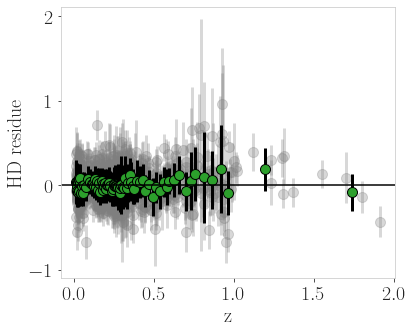

In [30]:
fig=plt.figure(figsize=(6,5))

data_z_sorted=data_exp_w_res.sort_values("z").reset_index(drop=True)
bins_z=[]
bins_res=[]
bins_err_res=[]
i=0
while i <len(data_z_sorted):
    bins_z.append(np.mean(data_z_sorted["z"][i:i+10]))
    bins_res.append(np.mean(data_z_sorted["residue"][i:i+10]))
    bins_err_res.append(np.mean(data_z_sorted["mu_err_exp"][i:i+10]))
    i+=10

plt.errorbar(data_z_sorted["z"],data_z_sorted["residue"],yerr=np.sqrt(data_z_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
plt.errorbar(bins_z,bins_res,yerr=np.sqrt(bins_err_res),marker='o',ls='none',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
#plt.plot(bins_z,bins_res,marker='o',ls='none',markersize=3,color="black",zorder=1)
plt.axhline(y = 0., color = 'black', linestyle = '-')
#plt.errorbar(data_exp["z"],mu_exp-mu(Om,Ol,M,red=data_exp["z"]),yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=3,color="#35b779")
plt.xlabel("z")
plt.ylabel("HD residue");

In [31]:
data_mB_sorted=data_exp_w_res.sort_values("mB").reset_index(drop=True)
bins_mB=[]
bins_res2=[]
bins_err_res2=[]
i=0
while i <len(data_z_sorted):
    bins_mB.append(np.mean(data_mB_sorted["mB"][i:i+10]))
    bins_res2.append(np.mean(data_mB_sorted["residue"][i:i+10]))
    bins_err_res2.append(np.mean(data_mB_sorted["mu_err_exp"][i:i+10]))
    i+=10

In [32]:
data_x1_sorted=data_exp_w_res.sort_values("x1").reset_index(drop=True)
bins_x1=[]
bins_res3=[]
bins_err_res3=[]
i=0
while i <len(data_z_sorted):
    bins_x1.append(np.mean(data_x1_sorted["x1"][i:i+10]))
    bins_res3.append(np.mean(data_x1_sorted["residue"][i:i+10]))
    bins_err_res3.append(np.mean(data_x1_sorted["mu_err_exp"][i:i+10]))
    i+=10

In [33]:
data_x2_sorted=data_exp_w_res.sort_values("x2").reset_index(drop=True)
bins_x2=[]
bins_res4=[]
bins_err_res4=[]
i=0
while i <len(data_x2_sorted):
    bins_x2.append(np.mean(data_x2_sorted["x2"][i:i+10]))
    bins_res4.append(np.mean(data_x2_sorted["residue"][i:i+10]))
    bins_err_res4.append(np.mean(data_x2_sorted["mu_err_exp"][i:i+10]))
    i+=10

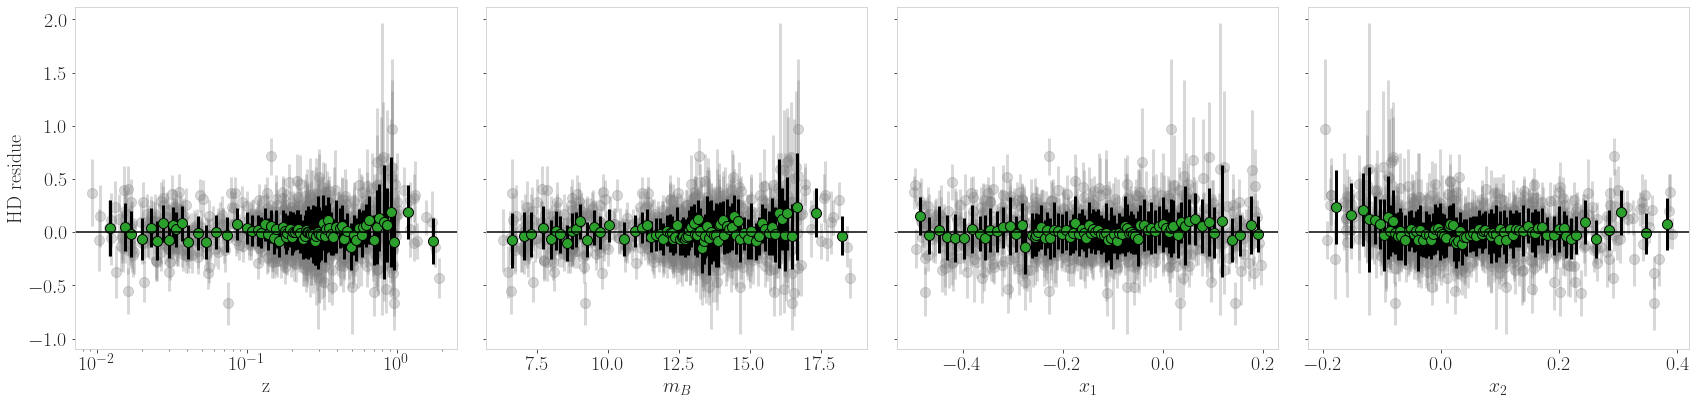

In [34]:
fig, axs=plt.subplots(1,4,figsize=(24,6),sharey=True)

axs[0].errorbar(data_z_sorted["z"],data_z_sorted["residue"],yerr=np.sqrt(data_z_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[0].errorbar(bins_z,bins_res,yerr=np.sqrt(bins_err_res),marker='o',ls='none',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[0].axhline(y = 0., color = 'black', linestyle = '-')
axs[0].set_xlabel("z")
axs[0].set_xscale('log')
axs[0].set_ylabel("HD residue")

axs[1].errorbar(data_mB_sorted["mB"],data_mB_sorted["residue"],yerr=np.sqrt(data_mB_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[1].errorbar(bins_mB,bins_res2,yerr=np.sqrt(bins_err_res2),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[1].axhline(y = 0., color = 'black', linestyle = '-')
axs[1].set_xlabel(r"$m_B$")

axs[2].errorbar(data_x1_sorted["x1"],data_x1_sorted["residue"],yerr=np.sqrt(data_x1_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[2].errorbar(bins_x1,bins_res3,yerr=np.sqrt(bins_err_res3),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[2].axhline(y = 0., color = 'black', linestyle = '-')
axs[2].set_xlabel(r"$x_1$")

axs[3].errorbar(data_x2_sorted["x2"],data_x2_sorted["residue"],yerr=np.sqrt(data_x2_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[3].errorbar(bins_x2,bins_res4,yerr=np.sqrt(bins_err_res4),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[3].axhline(y = 0., color = 'black', linestyle = '-')
axs[3].set_xlabel(r"$x_2$")

plt.tight_layout()
plt.savefig('./HD_residue_dependences_FA_varimax.pdf',dpi=300);

#### Comparisons with Host galaxy mass

In [35]:
reduced_data=data_exp_w_res[(data_exp_w_res["log_hm"]>=8.) & (data_exp_w_res["log_hm"]<=12.)]
data_log_hm_sorted=reduced_data.sort_values("log_hm").reset_index(drop=True)
bins_x1=[]
bins_x2=[]
bins_loghm=[]
bins_res=[]
i=0
while i <len(reduced_data):
    bins_x1.append(np.mean(data_log_hm_sorted["x1"][i:i+15]))
    bins_x2.append(np.mean(data_log_hm_sorted["x2"][i:i+15]))
    bins_loghm.append(np.mean(data_log_hm_sorted["log_hm"][i:i+15]))
    bins_res.append(np.mean(data_log_hm_sorted["residue"][i:i+15]))
    i+=15

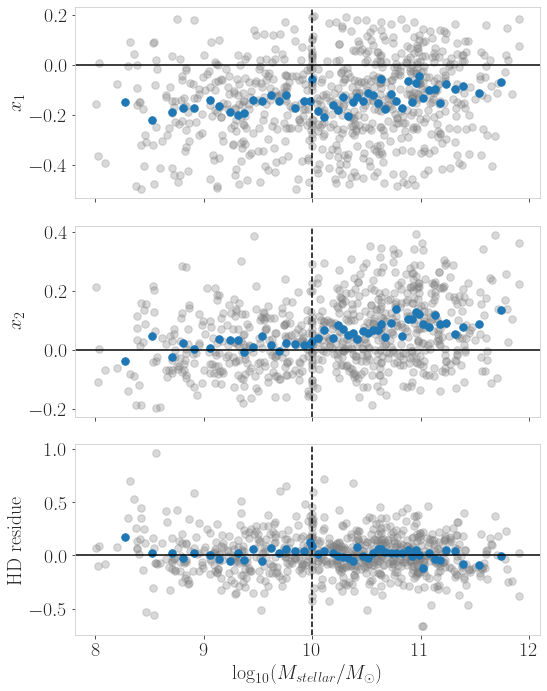

In [36]:
fig, axs=plt.subplots(3,1,figsize=(8,10),sharex=True)

axs[0].plot(reduced_data["log_hm"],reduced_data["x1"],'.',markersize=15,c="C7",alpha=0.3)
axs[0].plot(bins_loghm,bins_x1,".",markersize=15)
axs[0].axhline(0.,c="k")
axs[0].axvline(10.,ls="--",c="k")
axs[0].set_ylabel(r"$x_1$")

axs[1].plot(reduced_data["log_hm"],reduced_data["x2"],'.',markersize=15,c="C7",alpha=0.3)
axs[1].plot(bins_loghm,bins_x2,".",markersize=15)
axs[1].axhline(0.,c="k")
axs[1].axvline(10.,ls="--",c="k")
axs[1].set_ylabel(r"$x_2$")

axs[2].plot(reduced_data["log_hm"],reduced_data["residue"],'.',markersize=15,c="C7",alpha=0.3)
axs[2].plot(bins_loghm,bins_res,".",markersize=15)
axs[2].axhline(0.,c="k")
axs[2].axvline(10.,ls="--",c="k")
axs[2].set_xlabel(r"$\log_{10}(M_{stellar}/M_{\odot})$")
axs[2].set_ylabel("HD residue")

plt.tight_layout()
plt.savefig('./parameters_dep_w_host_mass_FA_varimax.pdf',dpi=300);

## Distance modulus differences scatter plot

In [37]:
Om_salt2=fit_results_salt2["Om"][0]
Ol_salt2=fit_results_salt2["Ol"][0]
M_salt2=fit_results_salt2["M"][0]
deltaM_salt2=fit_results_salt2["deltaM"][0]
alpha_salt2=fit_results_salt2["a"][0]
beta_salt2=fit_results_salt2["b"][0]
sigma_salt2=fit_results_salt2["sig"][0]

In [38]:
data_salt2=pd.read_csv("SALT2_FA_varimax_subsample_fits_table.txt")

In [39]:
data_salt2=data_salt2.sort_values("z").reset_index(drop=True)

In [40]:
mu_salt2=data_salt2["mB"]+alpha_salt2*data_salt2["x1"]-beta_salt2*data_salt2["x2"]-data_salt2["is_log_mass_g_10"]*deltaM_salt2

sigmaz=0.0012*(5/np.log(10.))*(1.+data_salt2["z"])/(data_salt2["z"]*(1.+data_salt2["z"]/2.))

cov=2.*alpha_salt2*data_salt2["cov_mB_x1"]+2*beta_salt2*data_salt2["cov_mB_x2"]-2*alpha_salt2*beta_salt2*data_salt2["cov_x1_x2"]
muerr_salt2=sigma_salt2**2+sigmaz**2+data_salt2["mBerr"]**2+alpha_salt2**2*data_salt2["x1err"]**2+beta_salt2**2*data_salt2["x2err"]**2+cov

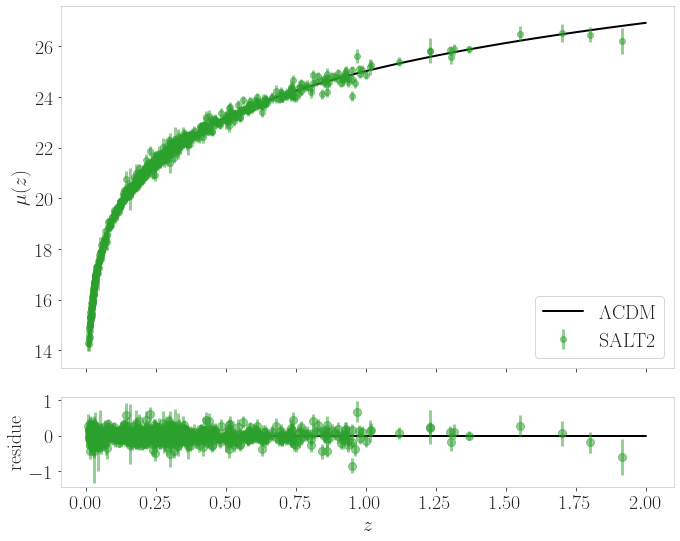

In [41]:
fig, ax=plt.subplots(2,1,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [4, 1]})

ax[0].errorbar(data_salt2["z"],mu_salt2, yerr=np.sqrt(muerr_salt2),ls="none",marker='o',markersize=6,color="C2",zorder=1,mec = 'C2', mfc = 'C2',elinewidth=3,label="SALT2",alpha=0.5)
ax[0].plot(np.linspace(0.01,2.,100),mu(Om_salt2,Ol_salt2,M_salt2,red=np.linspace(0.01,2.,100)),color="black",label=r"$\Lambda$CDM",lw=2,zorder=0)
ax[0].set_ylabel(r"$\mu(z)$")
ax[0].legend(loc=4)

ax[1].errorbar(data_salt2["z"],mu_salt2-mu(Om_salt2,Ol_salt2,M_salt2,red=data_salt2["z"]),yerr=np.sqrt(muerr_salt2),ls="none",marker='o',markersize=8,color="C2",zorder=1,mec = 'C2', mfc = 'C2',elinewidth=3,alpha=0.5)
ax[1].plot(np.linspace(0.01,2.,100),[0]*100,color="black",lw=2,zorder=0)
ax[1].set_ylabel("residue")
ax[1].set_xlabel(r"$z$")

fig.tight_layout();

In [42]:
len(data_salt2)

794

In [43]:
bins_z_comp=[]
bins_dif_comp=[]
mu_dif=mu_salt2-mu_exp
i=0
while i<len(data_salt2):
    bins_z_comp.append(np.mean(data_salt2["z"][i:i+25]))
    bins_dif_comp.append(np.mean(mu_dif[i:i+25]))
    i+=25

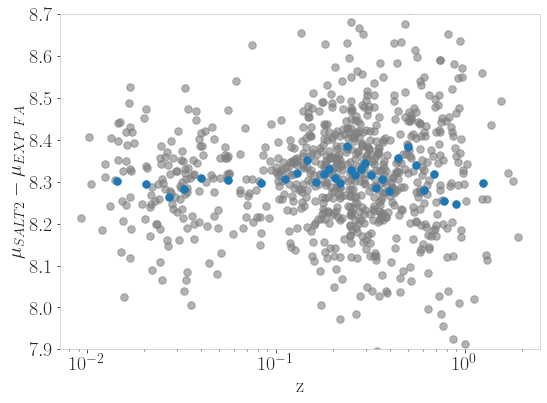

In [44]:
fig=plt.figure(figsize=(8,6))

plt.plot(data_salt2["z"],mu_salt2-mu_exp,'.',markersize=15,alpha=0.6,c="C7")
plt.plot(bins_z_comp,bins_dif_comp,'.',markersize=15)
plt.ylim(7.9,8.7) # THE GRAPH LIMIT IS REDUCED TO IMPROVE VISUALIZATION
plt.xlabel("z")
plt.ylabel(r"$\mu_{SALT2}-\mu_{EXP\,\, FA}$")
plt.xscale("log")
plt.tight_layout()
plt.savefig('./distance_mod_dif_evol_w_z_FA_varimax.pdf',dpi=300);

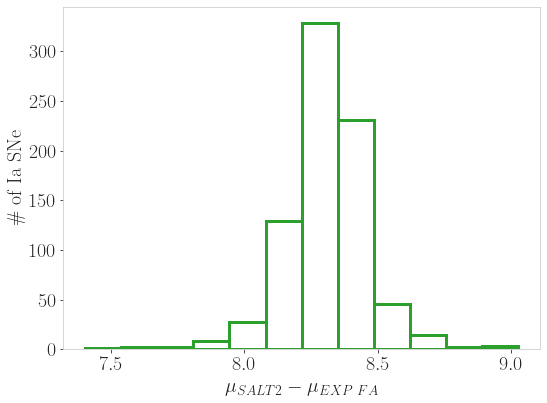

In [45]:
fig, ax=plt.subplots(figsize=(8,6))
                     
plt.hist(mu_salt2-mu_exp,bins=12,edgecolor="C2",fill=False,lw=3)
plt.ylabel("\# of Ia SNe")
plt.xlabel("$\mu_{SALT2}-\mu_{EXP\,\, FA}$")
plt.tight_layout()
plt.savefig('./distance_mod_dif_FA_varimax.pdf',dpi=300);

In [46]:
np.mean(mu_salt2-mu_exp)

8.310873748051192

In [47]:
np.std(mu_salt2-mu_exp)

0.15074147570258742

In [48]:
stats.skew(mu_salt2-mu_exp)

-0.3943712012501895

### Massa da galáxia hospedeira em função do survey 

In [49]:
PS1_sn=['34', '91', '142', '190', '199', '215', '236', '420', '20027',
       '20096', '20176', '30066', '40166', '40782', '50005', '50203',
       '50251', '50293', '70955', '80723', '90201', '91869', '100090',
       '100213', '100405', '110033', '110478', '110719', '110734',
       '120085', '120094', '120336', '120400', '120585', '130308',
       '130514', '130862', '140181', '150509', '160039', '160099',
       '160197', '170428', '180166', '180561', '190230', '190260',
       '300105', '310025', '310073', '310091', '310161', '310238',
       '310574', '320258', '330022', '330089', '330128', '330146',
       '340334', '350078', '350083', '350233', '350548', '360112',
       '360140', '360156', '370098', '370333', '370356', '370428',
       '370563', '380279', '380378', '390471', '420159', '420407',
       '420417', '440008', '440042', '440162', '450175', '460003',
       '460105', '470008', '470041', '470232', '470244', '480064',
       '480464', '490008', '500004', '500057', '500100', '510251',
       '510578', '510638', '520062', '520077', '520188',
       '530112', '530219', '540163', '550041', '550154', '560121',
       '560152', '570062', '580235', '580275', '580300', '590005',
       '200132', '10', '14', '38', '137', '174', '196', '220', '10010',
       '20090', '30006', '40150', '40201', '50003', '50201', '50291',
       '50296', '50580', '70242', '80646', '90037', '90275', '100206',
       '100358', '110425', '110460', '110484', '110542', '110716',
       '110721', '120044', '120086', '120143', '120369', '130755',
       '140152', '150254', '150457', '160070', '160126', '160198',
       '180313', '190209', '190340', '310039', '310051', '310090',
       '310146', '310188', '310260', '320099', '330023', '330083',
       '340229', '350027', '350050', '350080', '350192',
       '350235', '350374', '350630', '360139', '360145', '370344',
       '370498', '370566', '370595', '380318', '390259', '390449',
       '420196', '420414', '430003', '440050', '440236', '440285',
       '440643', '450082', '460064', '470015', '470110', '490007',
       '490037', '500038', '500065', '500511', '510113', '510266',
       '510550', '510597', '520041', '520071', '530037', '530086',
       '530251', '550059', '550137', '550202', '560027', '570022',
       '570056', '580104', '580270', '580276', '590031',
       '520016', '380199']

In [50]:
SNLS_sn=['03D1au', '03D1ax', '03D1co', '03D1ew',
       '03D3ay', '03D4ag', '03D4cx', '03D4cz', '03D4di', '03D4fd',
       '03D4gg', '04D1dc', '04D1ff', '04D1hx', '04D1jg', '04D1ow',
       '04D1pd', '04D1pp', '04D1qd', '04D1rx', '04D1si', '04D2cf',
       '04D2fs', '04D2gc', '04D2kr', '04D2mh', '04D3co', '04D3do',
       '04D3fk', '04D3hn', '04D3lu', '04D3ml', '04D3nh', '04D4an',
       '04D4bq', '04D4gg', '04D4im', '04D4jr', '05D1cc', '05D1cl',
       '05D1dx', '05D1em', '05D1er', '05D1hm', '05D1ix', '05D1ke',
       '05D2ab', '05D2ah', '05D2bt', '05D2bw', '05D2ck', '05D2dt',
       '05D2dy', '05D2ec', '05D2hc', '05D2mp', '05D2ob', '05D3cf',
       '05D3cq', '05D3dd', '05D3gp', '05D3ha', '05D3hs', '05D3jk',
       '05D3jr', '05D3kp', '05D3kx', '05D3lb', '05D3lr', '05D3mn',
       '05D4af', '05D4bf', '05D4bj', '05D4cs', '05D4dt', '05D4dy',
       '05D4fg', '06D2bk', '06D2cc', '06D2fb', '06D2gb', '06D3do',
       '06D3ed', '06D3et', '06D3gh', '06D4bo', '06D4co', '06D4dh',
       '03D1aw', '03D1bp', '03D1fc', '03D3aw', '03D3ba', '03D3cd',
       '03D4at', '03D4cy', '03D4dh', '03D4dy', '03D4gf', '04D1de',
       '04D1hd', '04D1hy', '04D1jd', '04D1kj', '04D1oh', '04D1rh',
       '04D1sa', '04D1sk', '04D2an', '04D2fp', '04D2gb', '04D2gp',
       '04D2ja', '04D2mc', '04D2mj', '04D3cy', '04D3df', '04D3ez',
       '04D3gx', '04D3kr', '04D3mk', '04D3nr', '04D4bk', '04D4fx',
       '04D4hf', '04D4ib', '04D4in', '04D4jy', '05D1cb', '05D1ck',
       '05D1dn', '05D1ee', '05D1eo', '05D1iz', '05D1kl', '05D2ac',
       '05D2ay', '05D2bv', '05D2ci', '05D2ct', '05D2dw', '05D2eb',
       '05D2fq', '05D2he', '05D2le', '05D2my', '05D2nt', '05D3ax',
       '05D3ci', '05D3cx', '05D3gv', '05D3hh', '05D3ht', '05D3jh',
       '05D3jq', '05D3kt', '05D3la', '05D3lc', '05D3mq', '05D4ag',
       '05D4be', '05D4bm', '05D4cw', '05D4ef', '05D4ek', '05D4ff',
       '05D4fo', '05D4hn', '06D2ca', '06D2ck', '06D3df', '06D3dt',
       '06D3el', '06D3fp', '06D3gn', '06D4ba', '06D4bw', '06D4cl',
       '06D4cq']

In [51]:
SDSS_sn=['744', '1241', '1371', '1580', '1794', '2031', '2102',
       '2165', '2422', '2635', '2916', '2992', '3080', '3087', '3317',
       '3451', '4046', '5103', '5533', '5549', '5635', '5957', '5994',
       '6057', '6108', '6196', '6315', '6422', '6558', '6924', '7147',
       '7243', '8495', '8921', '9032', '9467', '12779', '12781', '12856',
       '12898', '12927', '12950', '12972', '13005', '13038', '13044',
       '13152', '13578', '13610', '13689', '13736', '13796', '14019',
       '14108', '14421', '14735', '14871', '14979', '15057', '15129',
       '15219', '15234', '15259', '15287', '15301', '15383', '15421',
       '15443', '15461', '15467', '15868', '15901', '16021',
       '16032', '16073', '16099', '16106', '16116', '16165', '16206',
       '16213', '16281', '17215', '17218', '17240', '17366', '17464',
       '17784', '17811', '17825', '17875', '17884', '18030', '18241',
       '18323', '18325', '18466', '18486', '18602', '18697', '18749',
       '18804', '18809', '18940', '18945', '18965', '19002',
       '19023', '19027', '19067', '19128', '19282', '19596', '19775',
       '19818', '19913', '19953', '19969', '19990', '20142', '20227',
       '20364', '20581', '21006', '21502', '722', '762', '774', '1253',
       '2017', '2308', '2372', '2440', '2533', '2561', '2789', '3199',
       '3452', '3592', '5391', '5395', '5550', '5717', '5736', '5751',
       '5844', '6137', '6249', '6304', '6406', '6649', '6780', '6933',
       '6936', '7143', '7473', '7512', '7876', '8046', '8719', '10028',
       '10434', '10805', '12843', '12853', '12855', '12860', '12928',
       '12971', '12977', '13025', '13070', '13072', '13135', '13305',
       '13641', '13655', '13830', '13835', '14157', '14261', '14284',
       '14298', '14437', '14456', '14481', '14846', '15132', '15171',
       '15203', '15222', '15356', '15365', '15425', '15433', '15648',
       '15872', '16072', '16100', '16259', '16276', '16350', '17186',
       '17208', '17223', '17253', '17332', '17340', '17435',
       '17605', '17629', '18415', '18463', '18485', '18612', '18650',
       '18740', '18768', '18787', '18807', '19008', '19101',
       '19543', '19658', '19702', '19968', '19992', '20064', '20106',
       '20144', '20345', '20625', '21034', '22075']

In [52]:
LOWZ_sn=['2001az', '2001en',
       '2001fe', '2001G', '2001ic', '2001V', '2002bf', '2002bz',
       '2002ck', '2002cr', '2002de', '2002dp', '2002eu', '2002he',
       '2002kf', '2003ae', '2003ch', '2003cq', '2003fa', '2003hu',
       '2003ic', '2003it', '2003iv', '2003U', '2004as', '2004L', '2004ef',
       '2005hf', '2005hj', '2005lz', '2005ms', '2005na', '2006ac',
       '2006ah', '2006ak', '2006al', '2006ax', '2006bq',
       '2006bw', '2006cj', '2006cp', '2006cq', '2006en', '2006ev',
       '2006gr', '2006is', '2006mo', '2006mp', '2006N', '2006oa',
       '2006on', '2006sr', '2006td', '2006te', '2007ae', '2007ap',
       '2007ar', '2007bd', '2007co', '2007cq', '2007F', '2007O', '2008af',
       '2008bf', '2008L', '2007A', '2007aj', '2007cb', '2007cc', '2007fb',
       '2007hu', '2007is', '2007kh', '2007kk', '2007nq', '2007ob',
       '2007su', '2008C', '2008Y', '2008ac', '2008ar', '2008bw', '2008by',
       '2008bz', '2008cf', '2008ds', '2008fr', '2008gb', '2008gl',
       '2009D', '2009ad', '2009an', '2009ds', '2008050', '2008051',
       '2009kk', '2009kq', '2009na', '2009nq', '2010H', 'PTF10bjs',
       '2004eo', '2004ey', '2004gu', '2005be', '2005bo', '2005el',
       '2005eq', '2005hc', '2005iq', '2005ki', '2005lu', '2006ef',
       '2006eq', '2006et', '2006lu', '2006py', '2007bc', '2008bq',
       '1993ac', '1993ae', '1994M', '1994Q', '1994S', '1995ak', '1996bl',
       '1996bv', '1996C', '1997dg', '1997E', '1997Y', '1998dk', '1998dx',
       '1998ec', '1998eg', '1999cc', '1999dq', '1999ef', '1999ej',
       '1999X', '2000B', '2000cf', '2000fa']

In [53]:
HST_sn=['Primo', 'geta', 'stone',
       'wilson', 'rutledge', 'Aphrodite', 'Eagle', 'Frodo', 'Gabi',
       'Koekemoer', 'Lancaster', 'Manipogo', 'Mcguire', 'Ombo',
       'Patuxent', 'Rakke', 'Thoth', 'Vilas', 'SCP05D0', 'SCP05D6']

In [54]:
PS1_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in PS1_sn]
SNLS_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in SNLS_sn]
SDSS_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in SDSS_sn]
LOWZ_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in LOWZ_sn]

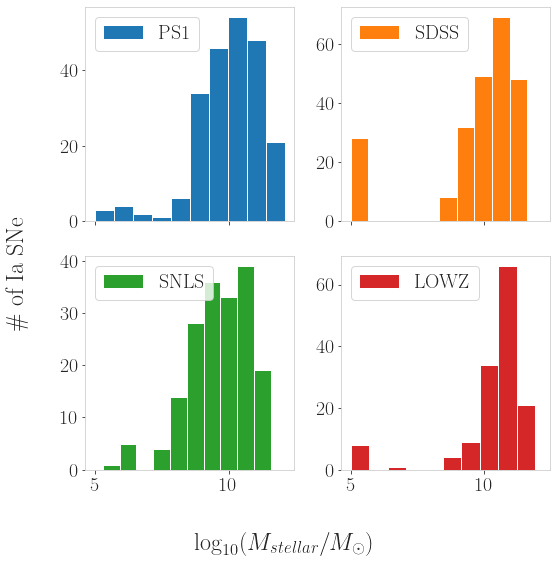

In [55]:
fig, axs=plt.subplots(2,2,figsize=(8,8),sharex=True)

axs[0,0].hist(PS1_log_hm,label="PS1",color="C0")
axs[0,0].legend()
axs[0,1].hist(SDSS_log_hm,label="SDSS",color="C1")
axs[0,1].legend()
axs[1,0].hist(SNLS_log_hm,label="SNLS",color="C2")
axs[1,0].legend()
axs[1,1].hist(LOWZ_log_hm,label="LOWZ",color="C3")
axs[1,1].legend()

fig.supxlabel(r"$\log_{10}(M_{stellar}/M_{\odot})$")
fig.supylabel(r"\# of Ia SNe")
fig.tight_layout()
plt.savefig('./distribution_hostmass_FA_varimax.pdf');